In [115]:
import numpy as np
import json
import codecs
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from model import my_aggclustering3

In [155]:
msdat_dir = '/home/hpms/Microsoft.IoT-Dump1.json'
with codecs.open(msdat_dir, 'r', 'utf-8-sig') as f:
    msdat = json.load(f)
msdat = pd.DataFrame(msdat)
msdat['Commands'] = [tuple(session) for session in msdat['Commands']]
msdat = msdat.drop_duplicates(subset='Commands').reset_index(drop=True)  # drop duplicates
msdat['Commands'] = [list(session) for session in msdat['Commands']]
msdat['Commands Length'] = [len(session) for session in msdat['Commands']]
msdat = msdat.sort_values(by='FirstSeen').reset_index(drop=True)

In [3]:
# sessions = []
# for session in msdat['Commands']:
#     sessions.append([])
#     for command in session:
#         sessions[-1] += command.split('; ')
# for no_below in range(1,10):
#     # tokenizer
#     tokenizer = RegexpTokenizer(r'[a-zA-Z0-9_\.\-\*]+')
#     commands_list = []
#     for session in sessions:
#         commands_list.append([])
#         for command in session:
#             command_token = tokenizer.tokenize(command)
#             commands_list[-1] += command_token
#     dictionary = Dictionary(commands_list)
#     dictionary.filter_extremes(no_below, 1.1)
#     print('no below {} has {} words'.format(no_below, len(dictionary)))

In [4]:
from nltk.tokenize import RegexpTokenizer
from gensim.corpora import Dictionary
def clean_commands(dat, no_below=2, no_above=1.1):
    """
    This function 
    1.splits multiple commands in the same line
    2. tokenize the commands
    3. replace rare commands by rarecommand
    
    :param dat: dataset
    :param no_below: Keep tokens which are contained in at least no_below documents.
    :param no_above: Keep tokens which are contained in no more than no_above documents 
    (fraction of total corpus size, not an absolute number).
    
    :return sessins_token_list: tokenized list of sessions of commands
    :return dictionary: dictionary generated
    """
    # for commands splitted by ;
    sessions = []
    for session in dat['Commands']:
        sessions.append([])
        for command in session:
            sessions[-1] += command.split('; ')
    # tokenizer
    tokenizer = RegexpTokenizer(r'[a-zA-Z0-9_\.\-\*]+')
    sessions_list = []
    commands_list = []
    for session in sessions:
        sessions_list.append([])
        commands_list.append([])
        for command in session:
            command_token = tokenizer.tokenize(command)
            sessions_list[-1] += [command_token]
            commands_list[-1] += command_token
    dictionary = Dictionary(commands_list)
    dictionary.filter_extremes(no_below, no_above)
    dictionary.id2token[-1] = 'rarecommand'  # repleace rare commands by rarecommand
    dictionary.token2id['rarecommand'] = -1
    sessions_token_list = []
    for session in sessions_list:
        sessions_token_list.append([])
        commands_token_list = []
        for command in session:
            idxs = dictionary.doc2idx(command)
            commands_token_list.append(' '.join([dictionary[idx] for idx in idxs]))
        sessions_token_list[-1] += commands_token_list
            
    return sessions_token_list, dictionary

In [5]:
sessions_token_list, dictionary = clean_commands(msdat, 1)

In [6]:
len(dictionary)

35713

In [7]:
msdat['Commands'] = sessions_token_list

In [8]:
alpha_cluster = 0.1
cluster_threshold = -0.3
alpha_label = 0.1
seq_len = 12

In [11]:
my_agg = my_aggclustering3(msdat, alpha_cluster, cluster_threshold, alpha_label, seq_len)
for depth in range(6):
    my_agg.fit()
with open('agg3_data_cleaned/aggclustering_1000_nofilter.pkl', 'wb') as f:
    pickle.dump(my_agg, f, protocol=4)

Depth 1: 

KeyboardInterrupt: 

In [12]:
with open('agg3_data_cleaned/aggclustering_1000_nofilter.pkl', 'rb') as f:
    my_agg = pickle.load(f)
max_depth = my_agg.depth
init_commands_clusters = my_agg.init_commands_clusters
posteriors = my_agg.posteriors
expected_predictive_probs = my_agg.expected_predictive_probs
weights = my_agg.weights

In [13]:
sorted_ws = []
xs = []
ys = []

for depth in range(max_depth):
    sorted_ws.append(sorted(weights[depth], reverse=True))
    xs.append([x for _, x in sorted(zip(weights[depth], init_commands_clusters[depth]), reverse=True)])
    ys.append([x for _, x in sorted(zip(weights[depth], expected_predictive_probs[depth]), reverse=True)])

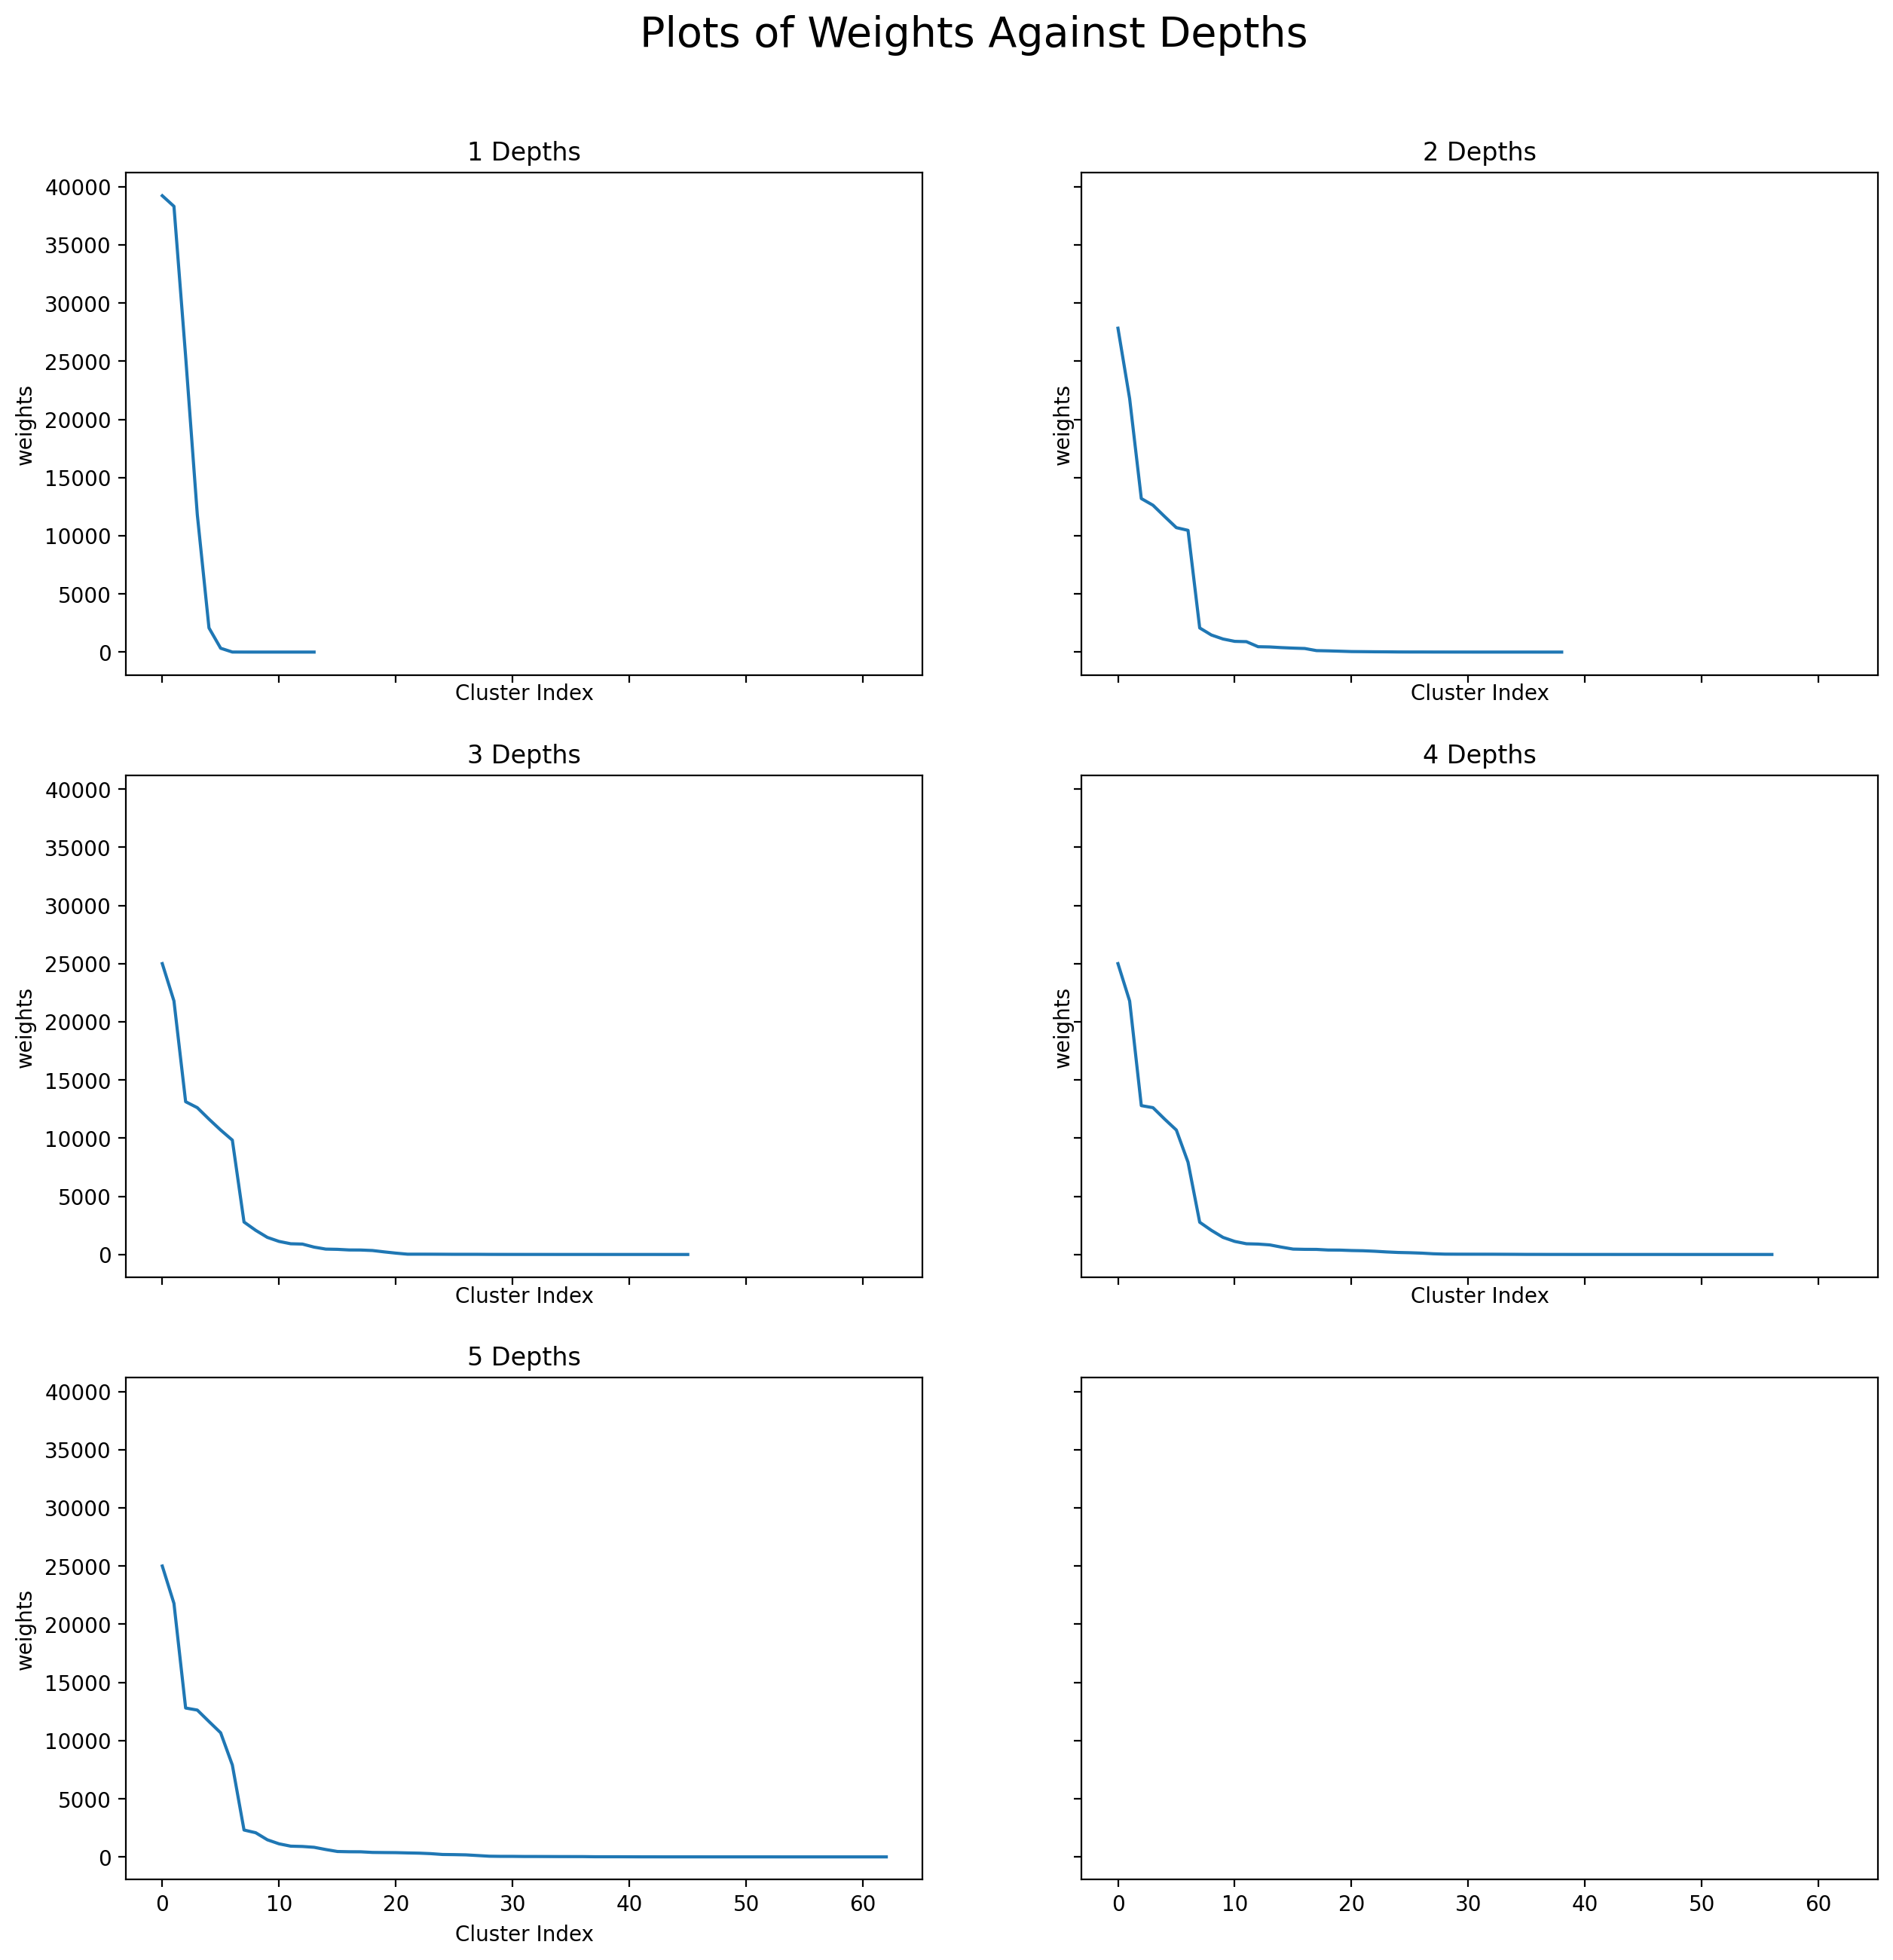

In [14]:
fig, ax = plt.subplots((max_depth+1)//2, 2, figsize=(15,15), dpi=200, sharex=True, sharey=True)
for depth in range(max_depth):
    sns.lineplot(x = [i for i in range(len(sorted_ws[depth]))], y = sorted_ws[depth],ax=ax[depth//2, depth%2])
    ax[depth//2, depth%2].set(title='{} Depths'.format(depth+1),
                              xlabel='Cluster Index',
                              ylabel='weights'
                             )
    fig.suptitle('Plots of Weights Against Depths',\
                 y = 0.95, fontsize=20
                )
plt.show()

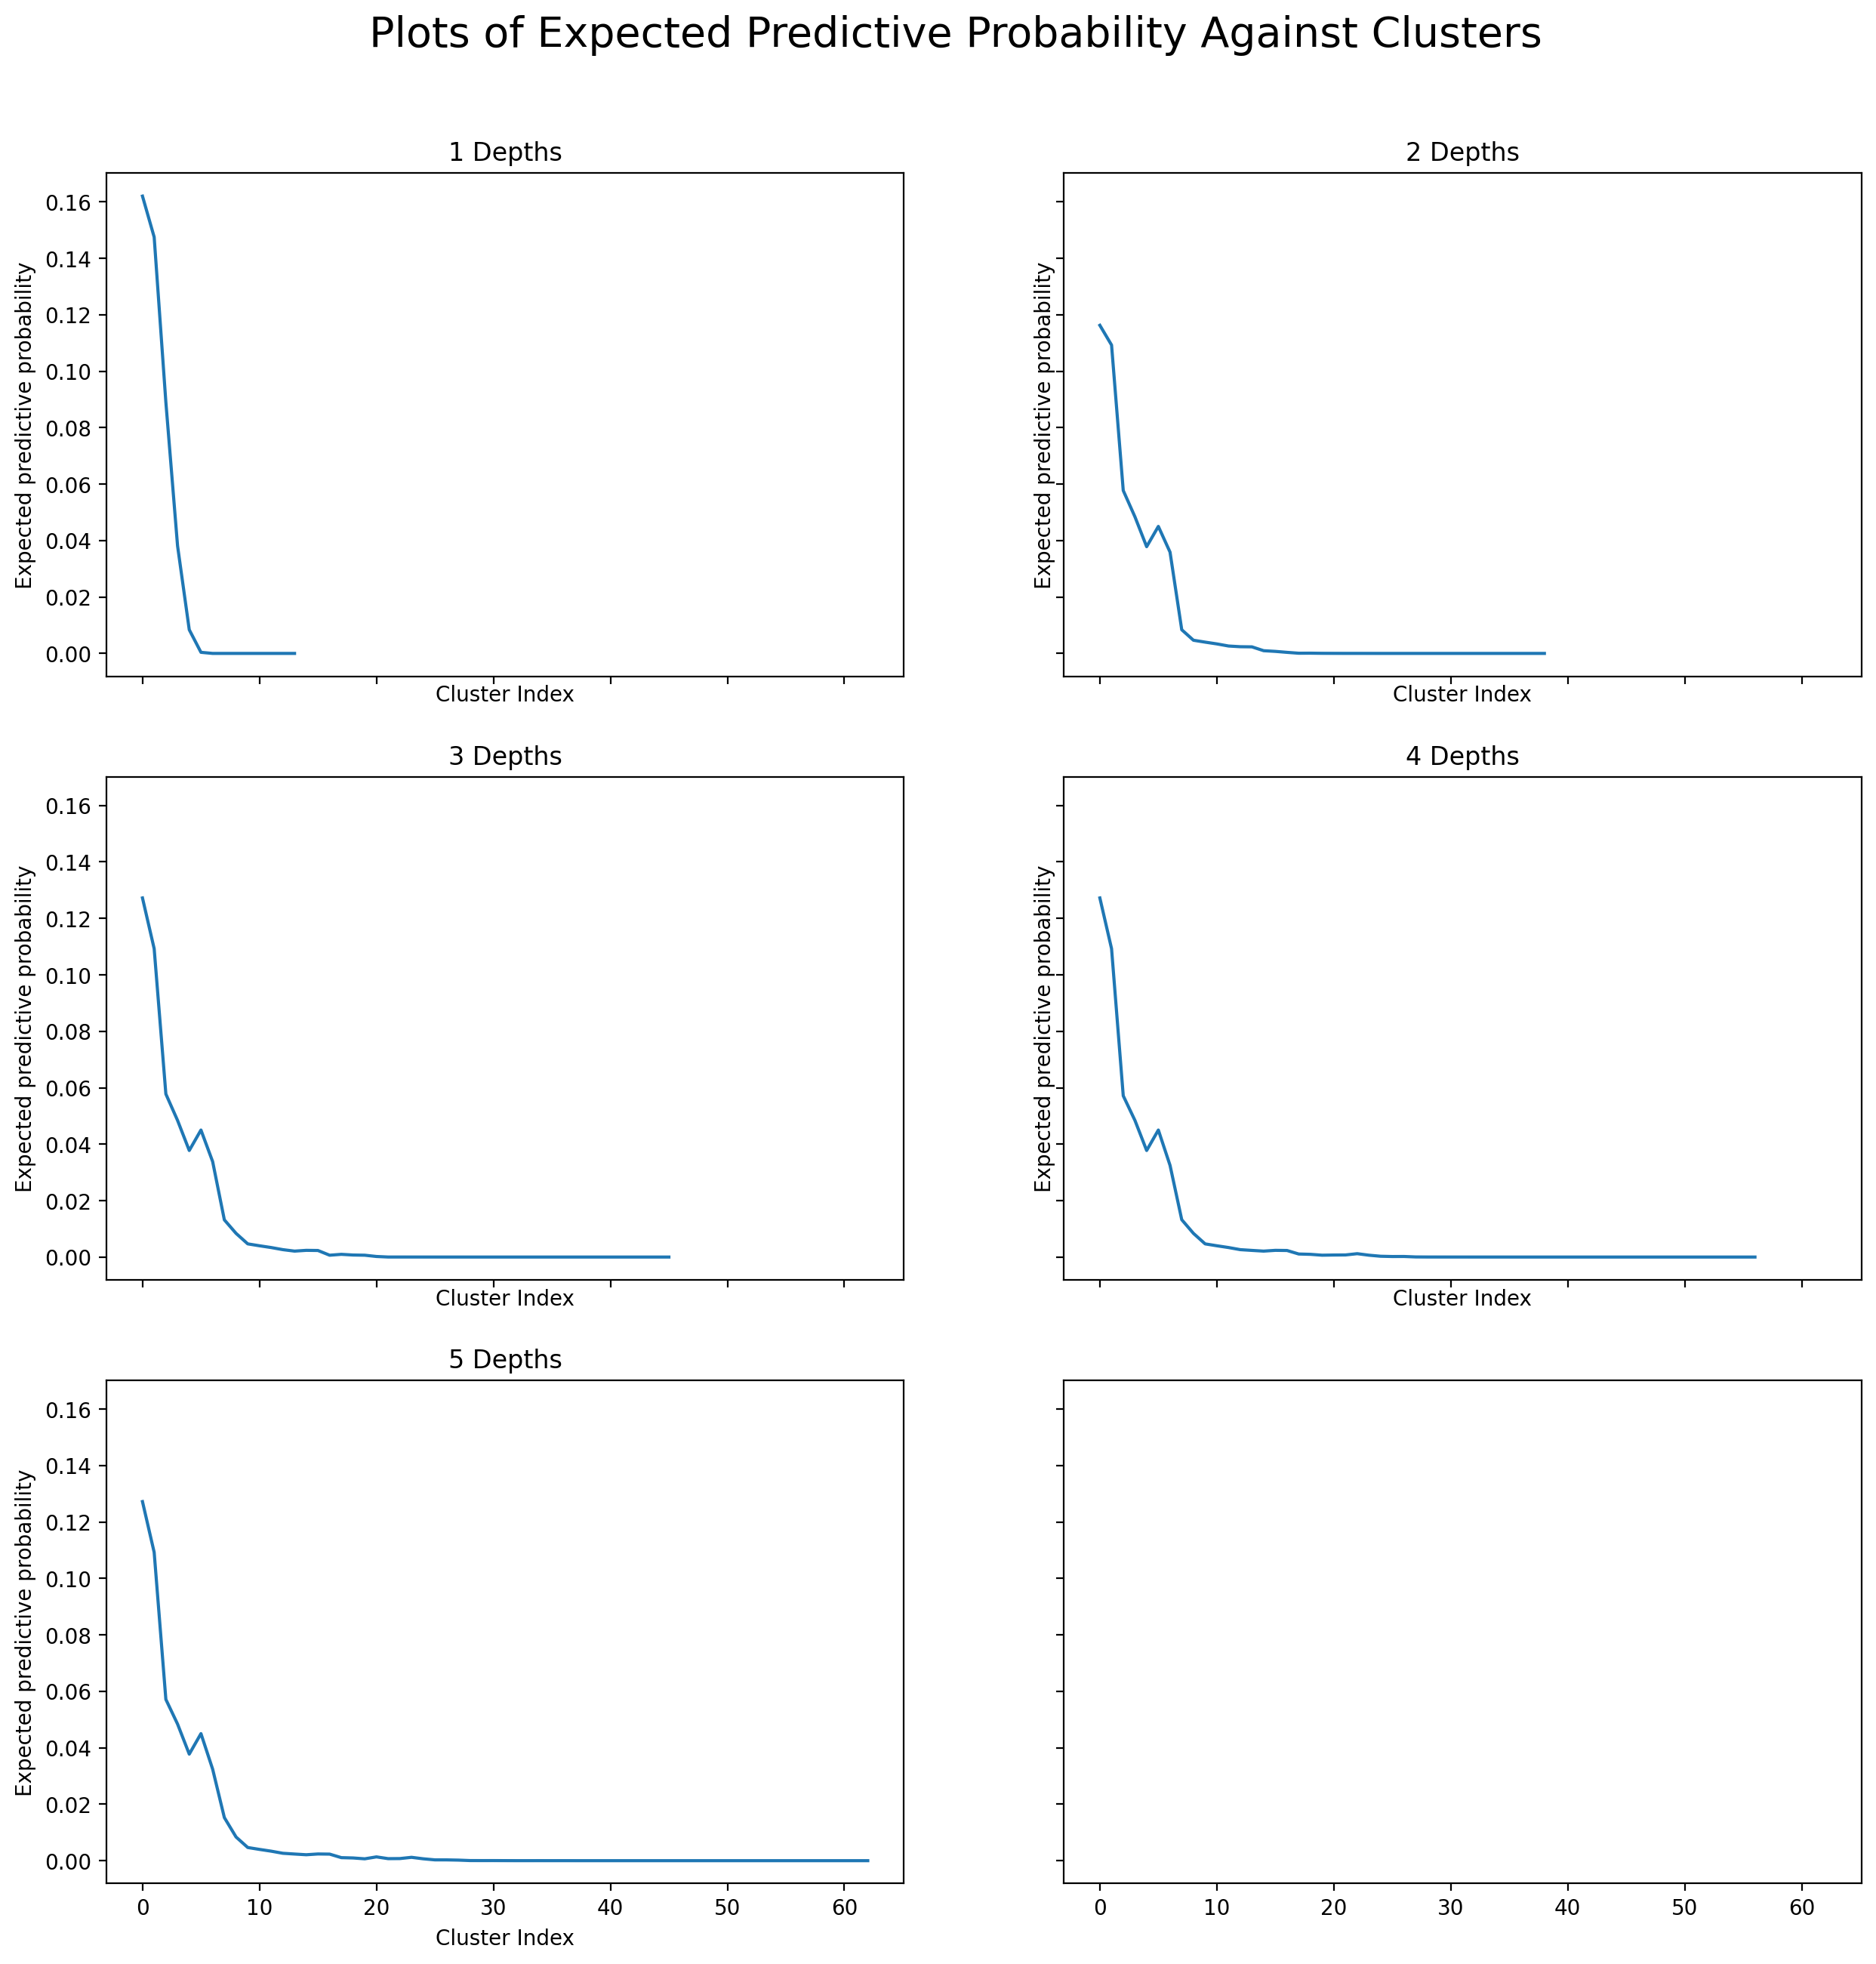

In [15]:
fig, ax = plt.subplots((max_depth+1)//2, 2, figsize=(15,15), dpi=200, sharex=True, sharey=True)
for depth in range(max_depth):
    sns.lineplot(x = [i for i in range(len(ys[depth]))], y = ys[depth],ax=ax[depth//2, depth%2])
    ax[depth//2, depth%2].set(title='{} Depths'.format(depth+1),
                              xlabel='Cluster Index',
                              ylabel='Expected predictive probability'
                             )
    fig.suptitle('Plots of Expected Predictive Probability Against Clusters',\
                 y = 0.95, fontsize=20
                )
plt.show()

In [16]:
print('Weighted expected predictive probs against depth are{}'.format([np.sum(y) for y in ys]))

Weighted expected predictive probs against depth are[0.4454805313158044, 0.480380293693982, 0.5055192191609394, 0.5095089352661196, 0.5130300369712172]


In [17]:
for k in range(len(ys[-1])):
    print(ys[-1][k]/sorted_ws[-1][k] * np.sum(sorted_ws[-1]))

0.5964529032373396
0.5877522783539547
0.5233085928765903
0.44955213764427476
0.38033503465974705
0.4946725438342572
0.4809706297990186
0.7742999017662806
0.47323277814692516
0.3721975826723365
0.4166117207463721
0.4277584816019859
0.3429075035902687
0.3342291821291226
0.3884676393826738
0.5996175451030044
0.614582118077722
0.2877091326386107
0.29300260047594273
0.20711489131257443
0.43016730776078804
0.2464079723884244
0.2718482918557294
0.4999823487335396
0.3758143066687872
0.17115585778390996
0.18874121869123064
0.1992010565873036
0.08014817587960579
0.07774206116858175
0.08978995477104236
0.06259013207702085
0.023676157941877204
0.027841258034928703
0.04217940813286521
0.025393717872742298
0.037385299282571574
0.012887267006714906
0.011293911474553626
0.007409133975184903
0.007073922834477475
0.0029750845813538065
0.002975084581353805
0.0017024742794840466
0.0017024742794840466
0.0017024742794840466
0.0017024742794840466
0.0012875341102057051
0.0012875341102057051
0.0012875341102057

In [21]:
sorted_ws[-1]

[24998,
 21785,
 12795,
 12618,
 11633,
 10664,
 7898,
 2311,
 2077,
 1469,
 1124,
 923,
 896,
 825,
 634,
 464,
 443,
 438,
 385,
 374,
 366,
 342,
 322,
 279,
 208,
 195,
 175,
 118,
 59,
 46,
 45,
 35,
 34,
 31,
 27,
 26,
 25,
 13,
 12,
 12,
 9,
 5,
 5,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [147]:
prob_df = pd.DataFrame(index=['Baseline 1', 'Baseline 2', '$l_c=3$', '$l_c=6$', '$l_c=9$', '$l_c=12$'])
cluster_df = pd.DataFrame(index=['Baseline 1', 'Baseline 2', '$l_c=3$', '$l_c=6$', '$l_c=9$', '$l_c=12$'])
for i in range(1,7):
    prob_df['Depth {}'.format(i)] = [np.sum(prob_list[i-1]) for prob_list in prob_lists]
    cluster_df['Depth {}'.format(i)] = [len(prob_list[i-1]) for prob_list in prob_lists]
prob_df = prob_df.replace({0:'NA'})
cluster_df = cluster_df.replace({0:'NA'})
prob_df.to_latex('table/prob_df.tex')
cluster_df.to_latex('table/cluster_df.tex')

In [139]:
cluster_df

,Depth 1,Depth 2,Depth 3,Depth 4,Depth 5,Depth 6
Baseline 1,1796,7380,14237,19537,19931,28116
Baseline 2,1,0,0,0,0,0
$l_c=3$,11,41,66,76,80,89
$l_c=6$,17,40,55,67,79,91
$l_c=9$,14,39,56,66,73,83
$l_c=12$,14,41,54,65,72,84


In [154]:
msdat.head().to_latex('table/head_df.tex')

In [161]:
msdat.loc[5,'Commands']

['enable',
 'system',
 'shell',
 'sh',
 '>/tmp/.ptmx && cd /tmp/',
 '>/var/.ptmx && cd /var/',
 '>/dev/.ptmx && cd /dev/',
 '>/mnt/.ptmx && cd /mnt/',
 '>/var/run/.ptmx && cd /var/run/',
 '>/var/tmp/.ptmx && cd /var/tmp/',
 '>/.ptmx && cd /',
 '>/dev/netslink/.ptmx && cd /dev/netslink/',
 '>/dev/shm/.ptmx && cd /dev/shm/',
 '>/bin/.ptmx && cd /bin/',
 '>/etc/.ptmx && cd /etc/',
 '>/boot/.ptmx && cd /boot/',
 '>/usr/.ptmx && cd /usr/',
 '/bin/busybox rm -rf lzrd oxdedfgt',
 '/bin/busybox cp /bin/busybox lzrd; >lzrd; /bin/busybox chmod 777 lzrd; /bin/busybox lizrd',
 '/bin/busybox cat /bin/busybox || while read i; do echo $i; done < /bin/busybox',
 '/bin/busybox lizrd']

In [162]:
with open('table/aggclustering_baseline.pkl', 'rb') as f:
    my_agg = pickle.load(f)
max_depth = my_agg.depth
init_commands_clusters = my_agg.init_commands_clusters
posteriors = my_agg.posteriors
expected_predictive_probs = my_agg.expected_predictive_probs
weights = my_agg.weights